In [1]:
import glob

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.models import resnet18, ResNet18_Weights
from tqdm import tqdm

In [2]:
# All files are extracted from the various paths
goodware_files = glob.glob("/Users/giuseppe/PycharmProjects/urbanSecurityGDGV/resources/goodware_dataset/*.exe")
malware_files = glob.glob("/Users/giuseppe/PycharmProjects/urbanSecurityGDGV/resources/malware_dataset/*")

# Unify the dataset
file_paths = malware_files + goodware_files
# To distinguish the various files, all malware is labelled with 1 and all goodware with 0
labels = [1] * len(malware_files) + [0] * len(goodware_files)

In [3]:
# Function that tranform a bytecode in an image
def exe_to_image(file_path, width=256):
    # Opens the file containing the bytecodes for reading
    with open(file_path, "rb") as f:
        byte_array = np.frombuffer(f.read(), dtype=np.uint8)

    # Save the bytcode lenght and computes the height of the image
    length = len(byte_array)
    height = int(np.ceil(length / width))

    # If the last row, hasn't 256 elements, it is completed with 0 padding to have always 256 elements for the image
    padded = np.pad(byte_array, (0, height * width - length), 'constant', constant_values=0)
    image = padded.reshape((height, width))

    # The Image.fromarray method is used to create an image from the NumPy array
    return Image.fromarray(image)

In [4]:
# This is the class that transorm every bytecode in a images custom Dataset for PyTorch
class EXEDataset(Dataset):
    # It takes a list of file paths and labels and returns a tuple of (image, label) for every file.
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Convert .exe file to image
        img = exe_to_image(self.file_paths[idx])
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label


In [5]:
# Each image is resized to give ResNet input images of the same size
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Standard ResNet resize
    transforms.Grayscale(num_output_channels=3),  # ResNet need 3 output channels
    transforms.ToTensor()
])

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [6]:
# ResNet18 definition
def create_model():
    model = resnet18(weights=ResNet18_Weights.DEFAULT) # With preprocessing
    model.fc = nn.Linear(model.fc.in_features, 2)  # Binary classification (instead of 1000 outputs)
    return model.to(torch.float32).to(device)

In [7]:
# Function that computes and returns the value of accuracy and F1-score of a model
def evaluate(model, dataloader):
    model.eval()
    all_preds = [] # List to store predicted labels
    all_labels = [] # List to store true labels

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    # Compute accuracy
    acc = accuracy_score(all_labels, all_preds)
    # Compute F1 score
    f1 = f1_score(all_labels, all_preds, average='macro')
    return acc, f1

In [8]:
# Class that implements the Early Stopping algorithms with a patience of 5 epochs based on F1-score value
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, f1_score):
        # Check the F1-score value
        if self.best_score is None or f1_score > self.best_score:
            self.best_score = f1_score
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [9]:
# Build the custom dataset
dataset = EXEDataset(file_paths, labels, transform)
# Use the StratifiedKFold with 10 folds
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracies = [] # List to store accuracies
f1_scores = [] # List to store F1-score
fold_lengths = [] # List to store fold lenghts
train_losses = [] # List to store train losses

for fold, (train_idx, val_idx) in enumerate(skf.split(file_paths, labels)):
    print(f"--- Fold {fold+1} ---")

    # Separate bytecodes in two sets: Training set and Test set
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)

    # Two PyTorch DataLoader objects are created
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32)

    # Create the model
    model = create_model()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # Definition of early stopping
    early_stopping = EarlyStopping(patience=5)

    # Various attributes
    best_f1 = 0
    patience = 5
    wait = 0
    epoch_count = 0

    # Training loop
    for epoch in range(50):
        # Train the model
        model.train()
        epoch_loss = 0
        epoch_count += 1

        for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=True):
            x, y = x.to(device, dtype=torch.float32), y.to(device)

            # Training steps
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Saving average loss
        train_losses.append(epoch_loss / len(train_loader))

        #Saving accuracy and F1-score
        acc, f1 = evaluate(model, val_loader)
        accuracies.append(acc)
        f1_scores.append(f1)
        tqdm.write(f"Accuracy: {acc:.4f} | F1-score: {f1:.4f}")

        # Early stopping algorithm
        if f1 > best_f1:
            best_f1 = f1
            wait = 0
            torch.save(model.state_dict(), "best_model.pt")
        else:
            wait += 1
            if wait >= patience:
                tqdm.write("Early stopping")
                break

    fold_lengths.append(epoch_count)

--- Fold 1 ---


Epoch 1: 100%|██████████| 237/237 [01:47<00:00,  2.21it/s]


Accuracy: 0.9122 | F1-score: 0.9119


Epoch 2: 100%|██████████| 237/237 [02:31<00:00,  1.56it/s]


Accuracy: 0.9217 | F1-score: 0.9216


Epoch 3: 100%|██████████| 237/237 [02:08<00:00,  1.84it/s]


Accuracy: 0.9300 | F1-score: 0.9299


Epoch 4: 100%|██████████| 237/237 [02:01<00:00,  1.96it/s]


Accuracy: 0.9324 | F1-score: 0.9323


Epoch 5: 100%|██████████| 237/237 [02:00<00:00,  1.96it/s]


Accuracy: 0.9383 | F1-score: 0.9383


Epoch 6: 100%|██████████| 237/237 [02:00<00:00,  1.97it/s]


Accuracy: 0.9205 | F1-score: 0.9201


Epoch 7: 100%|██████████| 237/237 [02:00<00:00,  1.97it/s]


Accuracy: 0.9407 | F1-score: 0.9406


Epoch 8: 100%|██████████| 237/237 [02:00<00:00,  1.97it/s]


Accuracy: 0.9442 | F1-score: 0.9441


Epoch 9: 100%|██████████| 237/237 [01:59<00:00,  1.98it/s]


Accuracy: 0.9407 | F1-score: 0.9405


Epoch 10: 100%|██████████| 237/237 [02:01<00:00,  1.95it/s]


Accuracy: 0.9383 | F1-score: 0.9383


Epoch 11: 100%|██████████| 237/237 [02:01<00:00,  1.96it/s]


Accuracy: 0.9395 | F1-score: 0.9393


Epoch 12: 100%|██████████| 237/237 [02:00<00:00,  1.97it/s]


Accuracy: 0.9431 | F1-score: 0.9429


Epoch 13: 100%|██████████| 237/237 [02:00<00:00,  1.96it/s]


Accuracy: 0.9336 | F1-score: 0.9335
Early stopping
--- Fold 2 ---


Epoch 1: 100%|██████████| 237/237 [02:01<00:00,  1.95it/s]


Accuracy: 0.9134 | F1-score: 0.9130


Epoch 2: 100%|██████████| 237/237 [02:02<00:00,  1.94it/s]


Accuracy: 0.9407 | F1-score: 0.9407


Epoch 3: 100%|██████████| 237/237 [02:00<00:00,  1.97it/s]


Accuracy: 0.9312 | F1-score: 0.9311


Epoch 4: 100%|██████████| 237/237 [01:58<00:00,  2.00it/s]


Accuracy: 0.9324 | F1-score: 0.9323


Epoch 5: 100%|██████████| 237/237 [01:53<00:00,  2.09it/s]


Accuracy: 0.9371 | F1-score: 0.9369


Epoch 6: 100%|██████████| 237/237 [01:48<00:00,  2.19it/s]


Accuracy: 0.9466 | F1-score: 0.9465


Epoch 7: 100%|██████████| 237/237 [01:45<00:00,  2.24it/s]


Accuracy: 0.9371 | F1-score: 0.9370


Epoch 8: 100%|██████████| 237/237 [01:46<00:00,  2.22it/s]


Accuracy: 0.9514 | F1-score: 0.9513


Epoch 9: 100%|██████████| 237/237 [01:47<00:00,  2.21it/s]


Accuracy: 0.9419 | F1-score: 0.9418


Epoch 10: 100%|██████████| 237/237 [01:46<00:00,  2.22it/s]


Accuracy: 0.9442 | F1-score: 0.9441


Epoch 11: 100%|██████████| 237/237 [01:46<00:00,  2.23it/s]


Accuracy: 0.9490 | F1-score: 0.9489


Epoch 12: 100%|██████████| 237/237 [01:46<00:00,  2.22it/s]


Accuracy: 0.9419 | F1-score: 0.9417


Epoch 13: 100%|██████████| 237/237 [01:53<00:00,  2.10it/s]


Accuracy: 0.9407 | F1-score: 0.9407
Early stopping
--- Fold 3 ---


Epoch 1: 100%|██████████| 237/237 [01:42<00:00,  2.30it/s]


Accuracy: 0.9265 | F1-score: 0.9262


Epoch 2: 100%|██████████| 237/237 [01:43<00:00,  2.29it/s]


Accuracy: 0.9265 | F1-score: 0.9262


Epoch 3: 100%|██████████| 237/237 [01:47<00:00,  2.20it/s]


Accuracy: 0.9063 | F1-score: 0.9055


Epoch 4: 100%|██████████| 237/237 [01:45<00:00,  2.24it/s]


Accuracy: 0.9395 | F1-score: 0.9394


Epoch 5: 100%|██████████| 237/237 [02:00<00:00,  1.97it/s]


Accuracy: 0.9359 | F1-score: 0.9358


Epoch 6: 100%|██████████| 237/237 [01:52<00:00,  2.12it/s]


Accuracy: 0.9442 | F1-score: 0.9441


Epoch 7: 100%|██████████| 237/237 [02:02<00:00,  1.93it/s]


Accuracy: 0.9371 | F1-score: 0.9371


Epoch 8: 100%|██████████| 237/237 [01:50<00:00,  2.14it/s]


Accuracy: 0.9419 | F1-score: 0.9418


Epoch 9: 100%|██████████| 237/237 [01:52<00:00,  2.10it/s]


Accuracy: 0.9359 | F1-score: 0.9359


Epoch 10: 100%|██████████| 237/237 [01:50<00:00,  2.14it/s]


Accuracy: 0.9431 | F1-score: 0.9430


Epoch 11: 100%|██████████| 237/237 [01:49<00:00,  2.16it/s]


Accuracy: 0.9442 | F1-score: 0.9442


Epoch 12: 100%|██████████| 237/237 [01:50<00:00,  2.14it/s]


Accuracy: 0.9466 | F1-score: 0.9466


Epoch 13: 100%|██████████| 237/237 [01:52<00:00,  2.11it/s]


Accuracy: 0.9490 | F1-score: 0.9489


Epoch 14: 100%|██████████| 237/237 [01:50<00:00,  2.14it/s]


Accuracy: 0.9466 | F1-score: 0.9466


Epoch 15: 100%|██████████| 237/237 [01:50<00:00,  2.15it/s]


Accuracy: 0.9466 | F1-score: 0.9465


Epoch 16: 100%|██████████| 237/237 [01:51<00:00,  2.13it/s]


Accuracy: 0.9241 | F1-score: 0.9236


Epoch 17: 100%|██████████| 237/237 [01:51<00:00,  2.13it/s]


Accuracy: 0.9466 | F1-score: 0.9466


Epoch 18: 100%|██████████| 237/237 [01:51<00:00,  2.12it/s]


Accuracy: 0.9466 | F1-score: 0.9466
Early stopping
--- Fold 4 ---


Epoch 1: 100%|██████████| 237/237 [01:46<00:00,  2.22it/s]


Accuracy: 0.9158 | F1-score: 0.9152


Epoch 2: 100%|██████████| 237/237 [02:00<00:00,  1.97it/s]


Accuracy: 0.9324 | F1-score: 0.9321


Epoch 3: 100%|██████████| 237/237 [01:59<00:00,  1.98it/s]


Accuracy: 0.9502 | F1-score: 0.9502


Epoch 4: 100%|██████████| 237/237 [01:58<00:00,  2.00it/s]


Accuracy: 0.9490 | F1-score: 0.9490


Epoch 5: 100%|██████████| 237/237 [01:57<00:00,  2.02it/s]


Accuracy: 0.9502 | F1-score: 0.9502


Epoch 6: 100%|██████████| 237/237 [01:55<00:00,  2.05it/s]


Accuracy: 0.9395 | F1-score: 0.9395


Epoch 7: 100%|██████████| 237/237 [01:48<00:00,  2.19it/s]


Accuracy: 0.9537 | F1-score: 0.9537


Epoch 8: 100%|██████████| 237/237 [01:45<00:00,  2.24it/s]


Accuracy: 0.9466 | F1-score: 0.9466


Epoch 9: 100%|██████████| 237/237 [01:46<00:00,  2.22it/s]


Accuracy: 0.9561 | F1-score: 0.9561


Epoch 10: 100%|██████████| 237/237 [01:46<00:00,  2.22it/s]


Accuracy: 0.9585 | F1-score: 0.9585


Epoch 11: 100%|██████████| 237/237 [01:47<00:00,  2.20it/s]


Accuracy: 0.9609 | F1-score: 0.9608


Epoch 12: 100%|██████████| 237/237 [01:47<00:00,  2.20it/s]


Accuracy: 0.9537 | F1-score: 0.9537


Epoch 13: 100%|██████████| 237/237 [01:48<00:00,  2.18it/s]


Accuracy: 0.9454 | F1-score: 0.9454


Epoch 14: 100%|██████████| 237/237 [01:47<00:00,  2.20it/s]


Accuracy: 0.9537 | F1-score: 0.9537


Epoch 15: 100%|██████████| 237/237 [01:46<00:00,  2.22it/s]


Accuracy: 0.9561 | F1-score: 0.9561


Epoch 16: 100%|██████████| 237/237 [01:48<00:00,  2.19it/s]


Accuracy: 0.9620 | F1-score: 0.9620


Epoch 17: 100%|██████████| 237/237 [01:47<00:00,  2.21it/s]


Accuracy: 0.9490 | F1-score: 0.9490


Epoch 18: 100%|██████████| 237/237 [01:45<00:00,  2.24it/s]


Accuracy: 0.9561 | F1-score: 0.9561


Epoch 19: 100%|██████████| 237/237 [01:44<00:00,  2.26it/s]


Accuracy: 0.9383 | F1-score: 0.9383


Epoch 20: 100%|██████████| 237/237 [01:45<00:00,  2.24it/s]


Accuracy: 0.9490 | F1-score: 0.9490


Epoch 21: 100%|██████████| 237/237 [01:46<00:00,  2.23it/s]


Accuracy: 0.9431 | F1-score: 0.9431
Early stopping
--- Fold 5 ---


Epoch 1: 100%|██████████| 237/237 [01:45<00:00,  2.25it/s]


Accuracy: 0.9229 | F1-score: 0.9228


Epoch 2: 100%|██████████| 237/237 [01:44<00:00,  2.27it/s]


Accuracy: 0.9324 | F1-score: 0.9323


Epoch 3: 100%|██████████| 237/237 [01:45<00:00,  2.24it/s]


Accuracy: 0.9217 | F1-score: 0.9215


Epoch 4: 100%|██████████| 237/237 [01:46<00:00,  2.23it/s]


Accuracy: 0.9217 | F1-score: 0.9216


Epoch 5: 100%|██████████| 237/237 [01:44<00:00,  2.27it/s]


Accuracy: 0.9241 | F1-score: 0.9241


Epoch 6: 100%|██████████| 237/237 [01:45<00:00,  2.24it/s]


Accuracy: 0.9348 | F1-score: 0.9347


Epoch 7: 100%|██████████| 237/237 [01:44<00:00,  2.26it/s]


Accuracy: 0.9241 | F1-score: 0.9240


Epoch 8: 100%|██████████| 237/237 [01:46<00:00,  2.22it/s]


Accuracy: 0.9265 | F1-score: 0.9265


Epoch 9: 100%|██████████| 237/237 [01:44<00:00,  2.26it/s]


Accuracy: 0.9288 | F1-score: 0.9287


Epoch 10: 100%|██████████| 237/237 [01:46<00:00,  2.22it/s]


Accuracy: 0.9181 | F1-score: 0.9181


Epoch 11: 100%|██████████| 237/237 [01:45<00:00,  2.26it/s]


Accuracy: 0.9324 | F1-score: 0.9323
Early stopping
--- Fold 6 ---


Epoch 1: 100%|██████████| 237/237 [01:46<00:00,  2.23it/s]


Accuracy: 0.9075 | F1-score: 0.9067


Epoch 2: 100%|██████████| 237/237 [01:46<00:00,  2.23it/s]


Accuracy: 0.9324 | F1-score: 0.9322


Epoch 3: 100%|██████████| 237/237 [01:46<00:00,  2.23it/s]


Accuracy: 0.9276 | F1-score: 0.9276


Epoch 4: 100%|██████████| 237/237 [01:45<00:00,  2.25it/s]


Accuracy: 0.9324 | F1-score: 0.9323


Epoch 5: 100%|██████████| 237/237 [01:46<00:00,  2.23it/s]


Accuracy: 0.9336 | F1-score: 0.9334


Epoch 6: 100%|██████████| 237/237 [01:44<00:00,  2.27it/s]


Accuracy: 0.9371 | F1-score: 0.9370


Epoch 7: 100%|██████████| 237/237 [01:44<00:00,  2.26it/s]


Accuracy: 0.9324 | F1-score: 0.9324


Epoch 8: 100%|██████████| 237/237 [01:45<00:00,  2.25it/s]


Accuracy: 0.9383 | F1-score: 0.9383


Epoch 9: 100%|██████████| 237/237 [01:44<00:00,  2.27it/s]


Accuracy: 0.9478 | F1-score: 0.9477


Epoch 10: 100%|██████████| 237/237 [01:44<00:00,  2.26it/s]


Accuracy: 0.9407 | F1-score: 0.9405


Epoch 11: 100%|██████████| 237/237 [01:46<00:00,  2.23it/s]


Accuracy: 0.9336 | F1-score: 0.9335


Epoch 12: 100%|██████████| 237/237 [01:44<00:00,  2.27it/s]


Accuracy: 0.9336 | F1-score: 0.9334


Epoch 13: 100%|██████████| 237/237 [01:44<00:00,  2.28it/s]


Accuracy: 0.9371 | F1-score: 0.9371


Epoch 14: 100%|██████████| 237/237 [01:45<00:00,  2.25it/s]


Accuracy: 0.9359 | F1-score: 0.9359
Early stopping
--- Fold 7 ---


Epoch 1: 100%|██████████| 237/237 [01:45<00:00,  2.24it/s]


Accuracy: 0.9287 | F1-score: 0.9287


Epoch 2: 100%|██████████| 237/237 [01:45<00:00,  2.25it/s]


Accuracy: 0.9204 | F1-score: 0.9202


Epoch 3: 100%|██████████| 237/237 [01:43<00:00,  2.29it/s]


Accuracy: 0.9252 | F1-score: 0.9250


Epoch 4: 100%|██████████| 237/237 [01:43<00:00,  2.28it/s]


Accuracy: 0.9335 | F1-score: 0.9333


Epoch 5: 100%|██████████| 237/237 [01:45<00:00,  2.25it/s]


Accuracy: 0.9311 | F1-score: 0.9310


Epoch 6: 100%|██████████| 237/237 [01:44<00:00,  2.26it/s]


Accuracy: 0.9276 | F1-score: 0.9274


Epoch 7: 100%|██████████| 237/237 [01:43<00:00,  2.29it/s]


Accuracy: 0.9287 | F1-score: 0.9287


Epoch 8: 100%|██████████| 237/237 [01:45<00:00,  2.24it/s]


Accuracy: 0.9252 | F1-score: 0.9251


Epoch 9: 100%|██████████| 237/237 [01:44<00:00,  2.27it/s]


Accuracy: 0.9252 | F1-score: 0.9250
Early stopping
--- Fold 8 ---


Epoch 1: 100%|██████████| 237/237 [01:44<00:00,  2.27it/s]


Accuracy: 0.9014 | F1-score: 0.9013


Epoch 2: 100%|██████████| 237/237 [01:43<00:00,  2.29it/s]


Accuracy: 0.9264 | F1-score: 0.9261


Epoch 3: 100%|██████████| 237/237 [01:47<00:00,  2.21it/s]


Accuracy: 0.9276 | F1-score: 0.9276


Epoch 4: 100%|██████████| 237/237 [01:51<00:00,  2.13it/s]


Accuracy: 0.9252 | F1-score: 0.9251


Epoch 5: 100%|██████████| 237/237 [01:58<00:00,  2.00it/s]


Accuracy: 0.9382 | F1-score: 0.9382


Epoch 6: 100%|██████████| 237/237 [01:55<00:00,  2.04it/s]


Accuracy: 0.9287 | F1-score: 0.9287


Epoch 7: 100%|██████████| 237/237 [01:52<00:00,  2.10it/s]


Accuracy: 0.9501 | F1-score: 0.9501


Epoch 8: 100%|██████████| 237/237 [01:54<00:00,  2.08it/s]


Accuracy: 0.9216 | F1-score: 0.9216


Epoch 9: 100%|██████████| 237/237 [01:56<00:00,  2.04it/s]


Accuracy: 0.9406 | F1-score: 0.9405


Epoch 10: 100%|██████████| 237/237 [01:54<00:00,  2.07it/s]


Accuracy: 0.9394 | F1-score: 0.9394


Epoch 11: 100%|██████████| 237/237 [01:52<00:00,  2.11it/s]


Accuracy: 0.9561 | F1-score: 0.9560


Epoch 12: 100%|██████████| 237/237 [01:50<00:00,  2.15it/s]


Accuracy: 0.9501 | F1-score: 0.9501


Epoch 13: 100%|██████████| 237/237 [01:50<00:00,  2.14it/s]


Accuracy: 0.9442 | F1-score: 0.9441


Epoch 14: 100%|██████████| 237/237 [01:49<00:00,  2.17it/s]


Accuracy: 0.9347 | F1-score: 0.9346


Epoch 15: 100%|██████████| 237/237 [01:51<00:00,  2.13it/s]


Accuracy: 0.9489 | F1-score: 0.9489


Epoch 16: 100%|██████████| 237/237 [01:50<00:00,  2.15it/s]


Accuracy: 0.9466 | F1-score: 0.9465
Early stopping
--- Fold 9 ---


Epoch 1: 100%|██████████| 237/237 [01:53<00:00,  2.10it/s]


Accuracy: 0.9323 | F1-score: 0.9323


Epoch 2: 100%|██████████| 237/237 [01:49<00:00,  2.16it/s]


Accuracy: 0.9228 | F1-score: 0.9228


Epoch 3: 100%|██████████| 237/237 [01:51<00:00,  2.13it/s]


Accuracy: 0.9371 | F1-score: 0.9370


Epoch 4: 100%|██████████| 237/237 [01:51<00:00,  2.13it/s]


Accuracy: 0.9371 | F1-score: 0.9370


Epoch 5: 100%|██████████| 237/237 [01:52<00:00,  2.11it/s]


Accuracy: 0.9394 | F1-score: 0.9393


Epoch 6: 100%|██████████| 237/237 [02:00<00:00,  1.97it/s]


Accuracy: 0.9371 | F1-score: 0.9371


Epoch 7: 100%|██████████| 237/237 [01:53<00:00,  2.08it/s]


Accuracy: 0.9394 | F1-score: 0.9394


Epoch 8: 100%|██████████| 237/237 [01:57<00:00,  2.01it/s]


Accuracy: 0.9406 | F1-score: 0.9406


Epoch 9: 100%|██████████| 237/237 [01:57<00:00,  2.02it/s]


Accuracy: 0.9371 | F1-score: 0.9370


Epoch 10: 100%|██████████| 237/237 [01:55<00:00,  2.05it/s]


Accuracy: 0.9347 | F1-score: 0.9346


Epoch 11: 100%|██████████| 237/237 [01:57<00:00,  2.02it/s]


Accuracy: 0.9276 | F1-score: 0.9275


Epoch 12: 100%|██████████| 237/237 [02:01<00:00,  1.95it/s]


Accuracy: 0.9264 | F1-score: 0.9263


Epoch 13: 100%|██████████| 237/237 [02:04<00:00,  1.90it/s]


Accuracy: 0.9311 | F1-score: 0.9311
Early stopping
--- Fold 10 ---


Epoch 1: 100%|██████████| 237/237 [02:01<00:00,  1.95it/s]


Accuracy: 0.9276 | F1-score: 0.9271


Epoch 2: 100%|██████████| 237/237 [01:57<00:00,  2.02it/s]


Accuracy: 0.9394 | F1-score: 0.9394


Epoch 3: 100%|██████████| 237/237 [02:01<00:00,  1.95it/s]


Accuracy: 0.9216 | F1-score: 0.9211


Epoch 4: 100%|██████████| 237/237 [01:58<00:00,  2.00it/s]


Accuracy: 0.9382 | F1-score: 0.9382


Epoch 5: 100%|██████████| 237/237 [02:00<00:00,  1.97it/s]


Accuracy: 0.9406 | F1-score: 0.9406


Epoch 6: 100%|██████████| 237/237 [02:09<00:00,  1.83it/s]


Accuracy: 0.9489 | F1-score: 0.9488


Epoch 7: 100%|██████████| 237/237 [02:07<00:00,  1.85it/s]


Accuracy: 0.9501 | F1-score: 0.9500


Epoch 8: 100%|██████████| 237/237 [01:52<00:00,  2.10it/s]


Accuracy: 0.9335 | F1-score: 0.9333


Epoch 9: 100%|██████████| 237/237 [02:02<00:00,  1.94it/s]


Accuracy: 0.9323 | F1-score: 0.9321


Epoch 10: 100%|██████████| 237/237 [01:53<00:00,  2.09it/s]


Accuracy: 0.9382 | F1-score: 0.9380


Epoch 11: 100%|██████████| 237/237 [01:54<00:00,  2.07it/s]


Accuracy: 0.9394 | F1-score: 0.9394


Epoch 12: 100%|██████████| 237/237 [02:00<00:00,  1.96it/s]


Accuracy: 0.9442 | F1-score: 0.9441
Early stopping



--- Final results (10-fold CV) ---
Average accuracy: 0.9366 ± 0.0112
Average f1-score: 0.9365 ± 0.0113


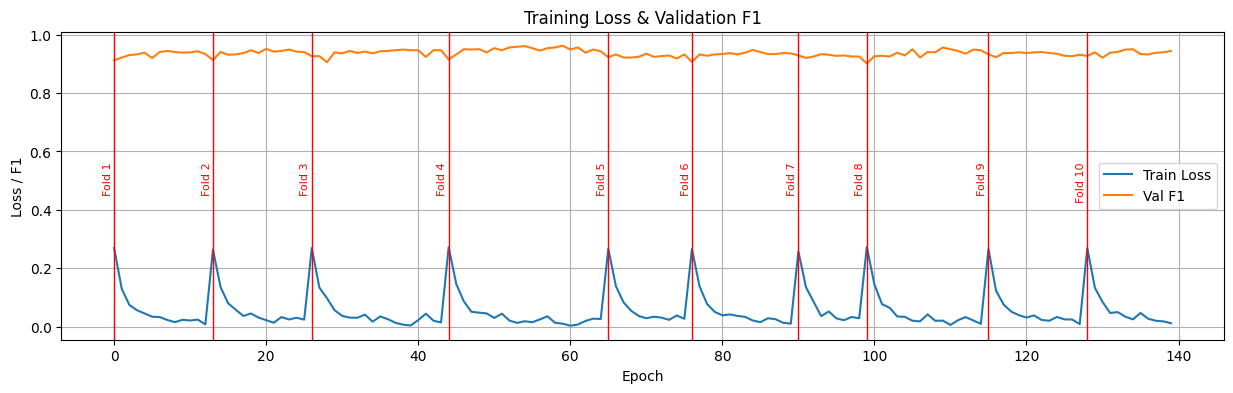

In [29]:
fold_end_positions = []
cumulative = 0
for length in fold_lengths:
    cumulative += length
    fold_end_positions.append(cumulative)

print("\n--- Final results (10-fold CV) ---")
print(f"Average accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Average f1-score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

fold_end_positions = [0] + fold_end_positions

plt.figure(figsize=(15, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(f1_scores, label='Val F1')
for i, pos in enumerate(fold_end_positions[:-1]):
    plt.axvline(x=pos, color='red', linestyle='-', linewidth=1)
    plt.text(x=pos - 1.5,
             y=plt.ylim()[1] * 0.56,
             s=f"Fold {i+1}",
             rotation=90,
             verticalalignment='top',
             color='red',
             fontsize=8)
plt.xlabel("Epoch")
plt.ylabel("Loss / F1")
plt.title("Training Loss & Validation F1")
plt.legend()
plt.grid()
plt.show()